In [ ]:
# import os
# import nibabel as nib
# import pandas as pd
# import pyradiomics
# # from pyradiomics import featureextractor
# import logging

# # Optional: suppress verbose logging
# logging.getLogger('radiomics').setLevel(logging.ERROR)

# # Path to your segmented tumor masks
# base_dir = r"C:\PKG - UPENN-GBM-NIfTI\UPENN-GBM\NIfTI-files\automated_segm"
# output_csv = "tumor_features.csv"

# # Configure feature extractor
# extractor = featureextractor.RadiomicsFeatureExtractor()
# extractor.enableAllFeatures()

# data = []

# for file in os.listdir(base_dir):
#     if file.endswith('.nii.gz'):
#         patient_id = file.split('_')[2] if '_' in file else file.split('.')[0]
#         path = os.path.join(base_dir, file)

#         # Since it's a binary tumor mask, use the same file as both image and mask
#         try:
#             result = extractor.execute(imageFilepath=path, maskFilepath=path)
#             filtered_result = {k: v for k, v in result.items() if "diagnostics" not in k}
#             filtered_result['PatientID'] = patient_id
#             data.append(filtered_result)
#         except Exception as e:
#             print(f"Failed for {file}: {e}")

# # Create DataFrame and save to CSV
# df = pd.DataFrame(data)
# df.set_index("PatientID", inplace=True)
# df.to_csv(output_csv)

# print(f"Saved {len(df)} feature vectors to {output_csv}")

ModuleNotFoundError: No module named 'pyradiomics'

In [ ]:
# import os
# import torch
# import torch.nn as nn
# import nibabel as nib
# import numpy as np
# import pandas as pd
# from scipy.ndimage import zoom

# # ======= 1. CNN Model (Simple 3D CNN as feature extractor) ============
# class TumorFeatureCNN(nn.Module):
#     def __init__(self):
#         super(TumorFeatureCNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             nn.Conv3d(1, 8, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool3d(2),
#             nn.Conv3d(8, 16, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool3d((4, 4, 4))  # Output shape: (16, 4, 4, 4)
#         )
#     def forward(self, x):
#         x = self.conv_layers(x)
#         return x.view(x.size(0), -1)  # Flatten features (batch_size, 1024)

# # ========= 2. NIfTI loader and preprocessing ===============
# def load_nifti(path, target_shape=(64, 64, 64)):
#     data = nib.load(path).get_fdata()
#     data = (data - data.min()) / (data.max() - data.min() + 1e-6)  # Normalize to [0, 1]
#     zoom_factors = [t / s for t, s in zip(target_shape, data.shape)]
#     data = zoom(data, zoom_factors, order=1)  # Resize
#     data = np.expand_dims(data, axis=0)  # Add channel dim (1, D, H, W)
#     return torch.tensor(data, dtype=torch.float32)

# # ========== 3. Feature Extraction Pipeline ================
# def extract_features_from_folder(folder_path):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = TumorFeatureCNN().to(device).eval()

#     features = []
#     patient_ids = []

#     for fname in os.listdir(folder_path):
#         if fname.endswith('.nii.gz'):
#             path = os.path.join(folder_path, fname)
#             # Extract everything before "_automated_approx_segm.nii.gz"
#             patient_id = fname.replace('_automated_approx_segm.nii.gz', '')

#             try:
#                 tensor = load_nifti(path).unsqueeze(0).to(device)
#                 with torch.no_grad():
#                     feat = model(tensor).cpu().numpy().flatten()
#                 features.append(feat)
#                 patient_ids.append(patient_id)
#             except Exception as e:
#                 print(f"[ERROR] {fname}: {e}")


#     df = pd.DataFrame(features)
#     df.insert(0, "PatientID", patient_ids)
#     return df

# # ========== 4. Run and Save to CSV ========================
# if __name__ == "__main__":
#     input_folder = r"C:\PKG - UPENN-GBM-NIfTI\UPENN-GBM\NIfTI-files\automated_segm"
#     output_csv = "cnn_tumor_features.csv"

#     df = extract_features_from_folder(input_folder)
#     df.to_csv(output_csv, index=False)
#     print(f"✅ Features extracted and saved to {output_csv}")

KeyboardInterrupt: 

In [ ]:
# import pandas as pd

# # File paths
# cnn_features_path = r'D:\mlpr data\Glioblastoma-ML-model\cnn_tumor_features.csv'
# clinical_info_path = r'D:\mlpr data\Glioblastoma-ML-model\UPENN-GBM_clinical_info_v2.1.csv'
# output_path = r'D:\mlpr data\Glioblastoma-ML-model\cnn_stacked.csv'

# # Load CSVs
# cnn_df = pd.read_csv(cnn_features_path)
# clinical_df = pd.read_csv(clinical_info_path)

# # Merge: match cnn_df.PatientID with clinical_df.ID
# merged_df = cnn_df.merge(
#     clinical_df[['ID', 'Survival_from_surgery_days_UPDATED']],
#     left_on='PatientID',
#     right_on='ID',
#     how='left'
# )

# # Drop redundant 'ID' column (optional)
# merged_df.drop(columns=['ID'], inplace=True)

# # Save result
# merged_df.to_csv(output_path, index=False)

# print("✅ Merged CSV saved as cnn_stacked.csv at:", output_path)


✅ Merged CSV saved as cnn_stacked.csv at: D:\mlpr data\Glioblastoma-ML-model\cnn_stacked.csv


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25, 50, 75])
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]
labels = [0, 1, 2, 3]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features and target
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Convert all to numeric and fill missing
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns

# Compute LDA-based feature importance
lda_temp = LinearDiscriminantAnalysis()
lda_temp.fit(X_scaled, y)
lda_importance = np.abs(lda_temp.coef_).sum(axis=0)

# Get top 420 features
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lda_importance
}).sort_values(by="Importance", ascending=False)

top_features = importance_df.head(420)["Feature"].tolist()
X = X[top_features]

# Re-scale selected features
X_scaled = scaler.fit_transform(X)

# LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.1, stratify=y, random_state=42)

# Balance classes
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(max_iter=1000)
lda_clf = LinearDiscriminantAnalysis()

ensemble_model = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    voting="hard"
)

stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
    final_estimator=RandomForestClassifier()
)

# Train and evaluate
stacking_clf.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

y_pred_stacking = stacking_clf.predict(X_test)
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_pred_stacking):.2f}")
print("Stacking Classification Report:\n", classification_report(y_test, y_pred_stacking))

print(f"Ensemble Model Accuracy: {accuracy_score(y_test, y_pred_ensemble):.2f}")
print("Ensemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))


d:\mlpr data\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\asp61\AppData\Local\Temp\ipykernel_40352\899421233.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Stacking Model Accuracy: 0.98
Stacking Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.94      0.97        16
           2       0.94      1.00      0.97        16
           3       1.00      1.00      1.00        16

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65

Ensemble Model Accuracy: 0.98
Ensemble Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16

    accuracy                           0.98        65
   macro avg       0.99      0.98      0.98        65
weighted avg       0.99      0.98      0.98        65



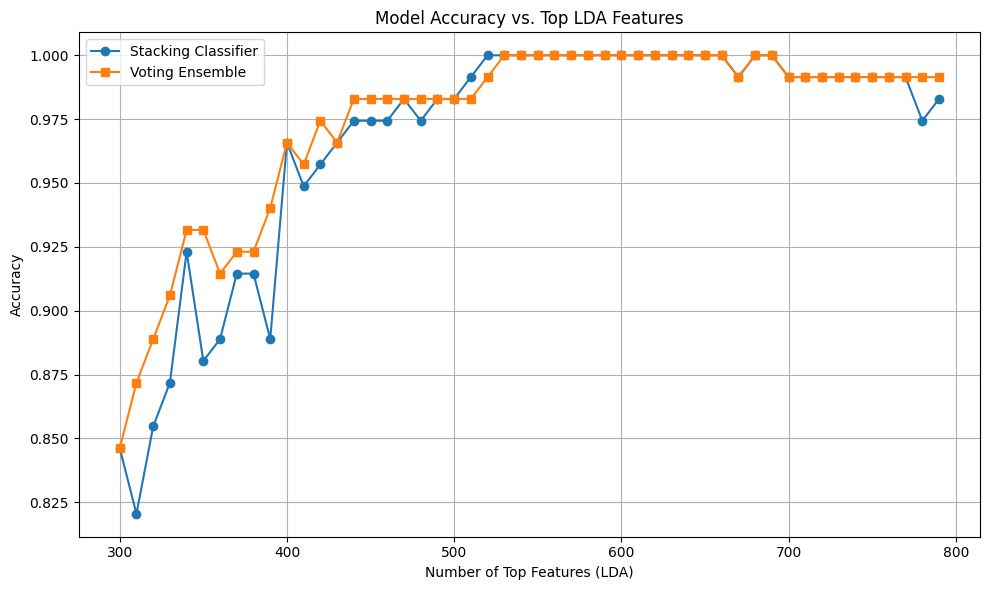

In [ ]:
# Load the dataset
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\cnn_stacked.csv"
df = pd.read_csv(file_path)

# Target pre-processing
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25, 50, 75])
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]
labels = [0, 1, 2, 3]
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features and target
X = df.drop(columns=[df.columns[0], "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Preprocess
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns

# LDA for feature importance
lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_scaled, y)
lda_importance = np.abs(lda.coef_).sum(axis=0)
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": lda_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Evaluation loop
feature_counts = list(range(300, min(800, len(X.columns)), 10))  # Adjust to max number of features
accuracies_stacking = []
accuracies_ensemble = []

for n in feature_counts:
    top_n = importance_df.head(n)["Feature"].tolist()
    X_sub = df[top_n].apply(pd.to_numeric, errors="coerce").fillna(df[top_n].median())
    X_scaled_sub = scaler.fit_transform(X_sub)

    # LDA transform
    lda = LinearDiscriminantAnalysis(n_components=3)
    X_lda = lda.fit_transform(X_scaled_sub, y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, stratify=y, random_state=42)

    # Balance classes
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Define models
    rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
    xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
    log_reg = LogisticRegression(max_iter=1000)
    lda_clf = LinearDiscriminantAnalysis()

    ensemble_model = VotingClassifier(
        estimators=[("RF", rf_clf), ("XGB", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
        voting="hard"
    )

    stacking_clf = StackingClassifier(
        estimators=[("RF", rf_clf), ("XGB", xgb_clf), ("LogReg", log_reg), ("LDA", lda_clf)],
        final_estimator=RandomForestClassifier()
    )

    # Train and evaluate
    ensemble_model.fit(X_train, y_train)
    stacking_clf.fit(X_train, y_train)

    y_pred_ensemble = ensemble_model.predict(X_test)
    y_pred_stacking = stacking_clf.predict(X_test)

    accuracies_ensemble.append(accuracy_score(y_test, y_pred_ensemble))
    accuracies_stacking.append(accuracy_score(y_test, y_pred_stacking))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, accuracies_stacking, marker='o', label="Stacking Classifier")
plt.plot(feature_counts, accuracies_ensemble, marker='s', label="Voting Ensemble")
plt.xlabel("Number of Top Features (LDA)")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Top LDA Features")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
lda.fit(X_scaled, y)
lda_importance = np.abs(lda.coef_).sum(axis=0)
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": lda_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Evaluation loop
importance_df.head(10)  # Adjust to max number of features

NameError: name 'lda' is not defined

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# Balanced Accuracy
balanced_acc_ensemble = balanced_accuracy_score(y_test, y_pred_ensemble)
balanced_acc_stacking = balanced_accuracy_score(y_test, y_pred_stacking)

print(f"Balanced Accuracy (Ensemble): {balanced_acc_ensemble:.2f}")
print(f"Balanced Accuracy (Stacking): {balanced_acc_stacking:.2f}")

Balanced Accuracy (Ensemble): 0.99
Balanced Accuracy (Stacking): 0.97


In [ ]:
from lifelines.utils import concordance_index

# Get original survival times for y_test samples
# Make sure the test set index aligns with the original dataframe
true_survival_times = y_test.copy()
true_survival_times = df.loc[y_test.index, "Survival_from_surgery_days_UPDATED"]

# Define bin midpoints (same binning as earlier)
bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)]

# Map predicted categories to survival time estimates
pred_survival_ensemble = [bin_midpoints[int(label)] for label in y_pred_ensemble]
pred_survival_stacking = [bin_midpoints[int(label)] for label in y_pred_stacking]

# Compute Concordance Index
c_index_ensemble = concordance_index(true_survival_times, pred_survival_ensemble)
c_index_stacking = concordance_index(true_survival_times, pred_survival_stacking)

print(f"Concordance Index (Ensemble): {c_index_ensemble:.2f}")
print(f"Concordance Index (Stacking): {c_index_stacking:.2f}")

Concordance Index (Ensemble): 0.88
Concordance Index (Stacking): 0.88


d:\mlpr data\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 2334/2340 [01:51<00:00]        

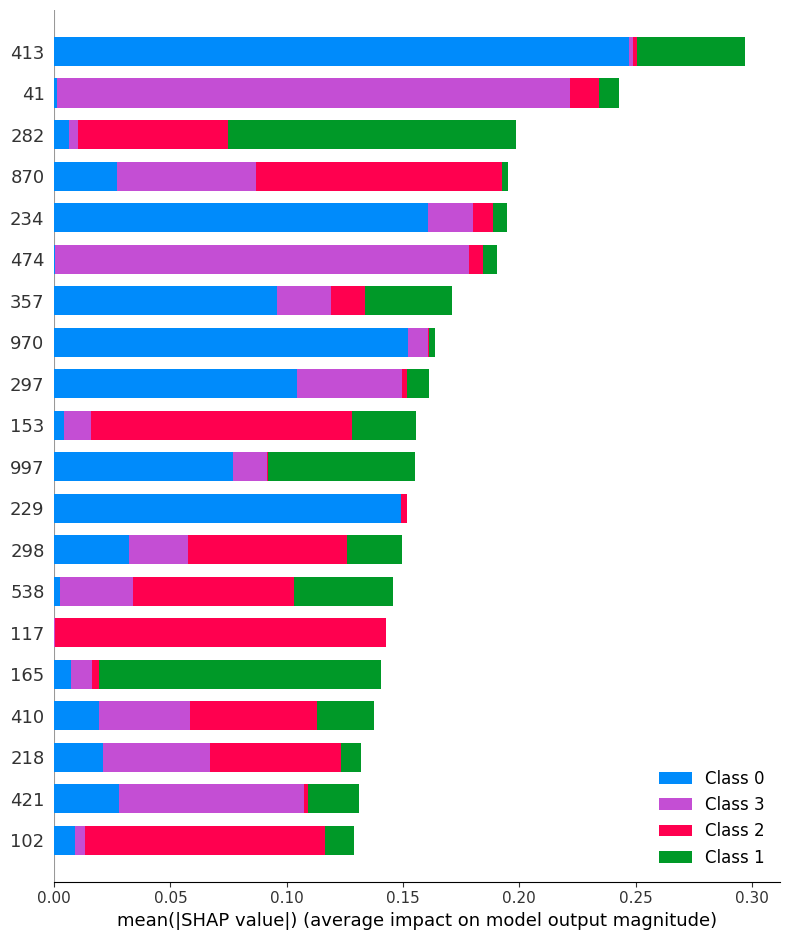

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (1024, 4)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
import shap

# Use original scaled data, not LDA-transformed (SHAP needs original features)
# So we'll fit one model (e.g., XGBoost) on X_scaled instead of X_lda
xgb_clf.fit(X_scaled, y)  # Refit on full data or use X_train if preferred

# Create SHAP explainer
explainer = shap.Explainer(xgb_clf, X_scaled)
shap_values = explainer(X_scaled)

# Plot global feature importance
shap.summary_plot(shap_values, X, plot_type="bar")

# Plot a single prediction explanation
shap.plots.waterfall(shap_values[0])  # for first sample